# BERT's Attention and Dependency Syntax

This notebook contains code for comparing BERT's attention to dependency syntax annotations (see Sections 4.2 and 5 of [What Does BERT Look At? An Analysis of BERT's Attention](https://arxiv.org/abs/1906.04341))

In [1]:
import collections
import pickle
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

# no eager execution
tf.compat.v1.disable_eager_execution()

2024-05-22 16:16:53.102135: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 16:16:53.140953: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 16:16:53.373498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 16:16:53.373758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 16:16:53.420785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

### Loading the data

Download the data used in this notebook from [here](https://drive.google.com/open?id=1DEIBQIl0Q0az5ZuLoy4_lYabIfLSKBg-). However, note that since Penn Treebank annotations are not public, this is dummy data where all labels are ROOT. See the README for extracting attention maps on your own data.

In [2]:
from copy import deepcopy
from typing import Dict, List, Tuple
import spacy
from thefuzz import fuzz, process
import logging

nlp = spacy.load("en_core_web_sm")
logging.getLogger().setLevel(logging.ERROR)

def get_word_info(words: List[str]) -> Tuple[List[int], List[str]]:
    """Gets the syntactic head and relationship to the head for each word in a sentence.
    
    Args:
        words: List of words in a sentence.

    Returns:
        Tuple of two lists:
        - List of indices of the syntactic head for each word.
        - List of relationship to the head for each word.
    """
    spaces = [True for _ in words]
    spaces[-1] = False
    
    doc = nlp(" ".join(words))
    tokens: Dict[str, List[int]] = {}
    for i, token in enumerate(doc):
        tokens.setdefault(token.text, {})
        tokens[token.text][i] = {
            "head_text": token.head.text,
            "head": token.head.i,
            "rel": token.dep_
        }

    def get_closest_token(word: str, i: int) -> Tuple[str, int]:
        token_text = process.extractOne(word, tokens.keys())[0]
        idx = min(tokens[token_text], key=lambda x: abs(x - i))
        return token_text, idx
    
    def get_closest_word(token: str, i: int) -> Tuple[str, int]:
        word, idx = min(enumerate(words), key=lambda x: (-fuzz.ratio(token, x[1]), abs(x[0] - i)))
        return word, idx

    # heads and rels must be same length as words, so we need to find
    # the nearest token for each word
    heads = []
    rels = []
    for i, word in enumerate(words):
        token_text, token_idx = get_closest_token(word, i)
        head_text = tokens[token_text][token_idx]["head_text"]
        head_idx = tokens[token_text][token_idx]["head"]
        rel = tokens[token_text][token_idx]["rel"]

        head_word_idx, head_word = get_closest_word(head_text, head_idx)

        heads.append(head_word_idx)
        rels.append(rel)
        

    assert(len(heads) == len(words))

    return heads, rels

In [3]:
print(get_word_info(["his", "juice", "is", "good"]))
print(get_word_info(["John", "is", "a", "good", "person"]))

([1, 2, 2, 2], ['poss', 'nsubj', 'ROOT', 'acomp'])
([1, 1, 4, 4, 1], ['nsubj', 'ROOT', 'det', 'amod', 'attr'])


In [4]:
def load_pickle(fname):
  with open(fname, "rb") as f:
    return pickle.load(f, encoding="latin1")  # add, encoding="latin1") if using python3 and downloaded data
    
dev_data_unprocessed = load_pickle("./data/depparse/dev_attn.pkl")

# The data consists of a list of examples (dicts)
# with the following keys/values
# {
#    "words": list of words in the sentence
#    "heads": index of each word"s syntactic head (0 for ROOT, 1 for the first 
#             word of the sentence, etc.)
#    "relns": the relation between each word and its head
#    "attns": [n_layers, n_heads, seq_len, seq_len] tensor of attention maps
#             from BERT
#}

dev_data = []
for i, example in enumerate(dev_data_unprocessed, start=1):
    print(f"Example {i}/{len(dev_data_unprocessed)}", end="\r")
    heads, rels = get_word_info(example["words"])
    dev_data.append({
        "words": example["words"],
        "heads": heads,
        "relns": rels,
        "attns": example["attns"]
    })
print("")

print("words:", dev_data[0]["words"])
print("heads:", dev_data[0]["heads"])
print("relns:", dev_data[0]["relns"])
# Attention maps are 9x9 because [CLS] and [SEP] are added
print("attns: a tensor with shape", dev_data[0]["attns"].shape)

Example 1696/1696
words: ['Influential', 'members', 'of', 'the', 'House', 'Ways', 'and', 'Means', 'Committee', 'introduced', 'legislation', 'that', 'would', 'restrict', 'how', 'the', 'new', 'savings-and-loan', 'bailout', 'agency', 'can', 'raise', 'capital', ',', 'creating', 'another', 'potential', 'obstacle', 'to', 'the', 'government', "'s", 'sale', 'of', 'sick', 'thrifts', '.']
heads: [1, 9, 1, 8, 8, 8, 5, 5, 2, 9, 9, 13, 13, 10, 21, 19, 19, 17, 19, 21, 21, 13, 21, 1, 21, 27, 27, 24, 24, 30, 32, 30, 28, 32, 35, 33, 1]
relns: ['amod', 'nsubj', 'prep', 'det', 'nmod', 'nmod', 'cc', 'conj', 'pobj', 'ROOT', 'dobj', 'nsubj', 'aux', 'relcl', 'advmod', 'det', 'amod', 'cc', 'compound', 'nsubj', 'aux', 'ccomp', 'dobj', 'amod', 'advcl', 'det', 'amod', 'dobj', 'prep', 'det', 'poss', 'case', 'pobj', 'prep', 'amod', 'pobj', 'amod']
attns: a tensor with shape (12, 12, 39, 39)


In [5]:
# Find the most common relations in our data
reln_counts = collections.Counter()
for example in dev_data:
  for reln in example["relns"]:
    reln_counts[reln] += 1
print(reln_counts.most_common(10))

[('prep', 4528), ('det', 4329), ('compound', 4207), ('pobj', 3576), ('nsubj', 3368), ('amod', 2549), ('ROOT', 1851), ('advmod', 1747), ('dobj', 1516), ('aux', 1259)]


### Evaluating individual heads at dependency syntax (Section 4.2)

In [6]:
# Code for evaluating individual attention maps and baselines

def evaluate_predictor(prediction_fn):
  """Compute accuracies for each relation for the given predictor."""
  n_correct, n_incorrect = collections.Counter(), collections.Counter()
  for example in dev_data:
    words = example["words"]
    predictions = prediction_fn(example)
    for i, (p, y, r) in enumerate(zip(predictions, example["heads"],
                                      example["relns"])):
      is_correct = (p == y)
      if r == "poss" and p < len(words):
        # Special case for poss (see discussion in Section 4.2)
        # print(i, len(words))
        # print(p, y, r)
        # print(words[p], words[y], r)
        if i < (len(words) - 1) and (words[i + 1] == "'s" or words[i + 1] == "s'"):
          is_correct = (predictions[i + 1] == y)
      if is_correct:
        n_correct[r] += 1
        n_correct["all"] += 1
      else:
        n_incorrect[r] += 1
        n_incorrect["all"] += 1
  return {k: n_correct[k] / float(n_correct[k] + n_incorrect[k])
          for k in n_incorrect.keys()}

def attn_head_predictor(layer, head, mode="normal"):
  """Assign each word the most-attended-to other word as its head."""
  def predict(example):
    attn = np.array(example["attns"][layer][head])
    if mode == "transpose":
      attn = attn.T
    elif mode == "both":
      attn += attn.T
    else:
      assert mode == "normal"
    # ignore attention to self and [CLS]/[SEP] tokens
    attn[range(attn.shape[0]), range(attn.shape[0])] = 0
    attn = attn[1:-1, 1:-1]
    return np.argmax(attn, axis=-1) + 1  # +1 because ROOT is at index 0
  return predict

def offset_predictor(offset):
  """Simple baseline: assign each word the word a fixed offset from
  it (e.g., the word to its right) as its head."""
  def predict(example):
    return [max(0, min(i + offset + 1, len(example["words"])))
            for i in range(len(example["words"]))]
  return predict

def get_scores(mode="normal"):
  """Get the accuracies of every attention head."""
  scores = collections.defaultdict(dict)
  for layer in range(12):
    for head in range(12):
      scores[layer][head] = evaluate_predictor(
          attn_head_predictor(layer, head, mode))
  return scores

# attn_head_scores[direction][layer][head][dep_relation] = accuracy
attn_head_scores = {
    "dep->head": get_scores("normal"),
    "head<-dep": get_scores("transpose")
}
# baseline_scores[offset][dep_relation] = accuracy
baseline_scores = {
    i: evaluate_predictor(offset_predictor(i)) for i in range(-3, 3)
}

In [7]:
def get_all_scores(reln):
  """Get all attention head scores for a particular relation."""
  all_scores = []
  for key, layer_head_scores in attn_head_scores.items():
    for layer, head_scores in layer_head_scores.items():
      for head, scores in head_scores.items():
        all_scores.append((scores[reln], layer, head, key))
  return sorted(all_scores, reverse=True)

In [8]:
# Compare the best attention head to baselines across the most common relations.
# This produces the scores in Table 1
for row, (reln, _) in enumerate([("all", 0)] + reln_counts.most_common()):
  if reln == "root" or reln == "punct":
    continue
  if reln_counts[reln] < 100 and reln != "all":
    break

  uas, layer, head, direction = sorted(
      s for s in get_all_scores(reln))[-1]
  baseline_uas, baseline_offset = max(
      (scores[reln], i) for i, scores in baseline_scores.items())
  print("{:8s} | {:5d} | attn: {:.1f} | offset={:2d}: {:.1f} | {:}-{:} {:}".format(
      reln[:8], reln_counts[reln], 100 * uas, baseline_offset, 100 * baseline_uas,
      layer, head, direction))

all      |     0 | attn: 13.0 | offset= 0: 26.7 | 3-3 head<-dep
prep     |  4528 | attn: 32.6 | offset=-2: 51.5 | 3-3 head<-dep
det      |  4329 | attn: 25.0 | offset= 0: 35.7 | 5-9 dep->head
compound |  4207 | attn: 11.9 | offset= 0: 68.1 | 7-4 head<-dep
pobj     |  3576 | attn: 26.6 | offset=-3: 36.1 | 5-3 dep->head
nsubj    |  3368 | attn: 17.4 | offset= 0: 43.9 | 6-11 head<-dep
amod     |  2549 | attn: 19.0 | offset= 0: 57.9 | 7-4 head<-dep
ROOT     |  1851 | attn: 89.8 | offset=-1: 93.6 | 1-4 dep->head
advmod   |  1747 | attn: 10.2 | offset= 0: 35.0 | 3-3 head<-dep
dobj     |  1516 | attn: 29.4 | offset=-3: 37.4 | 5-8 head<-dep
aux      |  1259 | attn: 19.3 | offset= 0: 74.9 | 2-9 dep->head
cc       |  1196 | attn: 28.0 | offset=-2: 35.9 | 3-11 dep->head
nummod   |  1026 | attn: 11.4 | offset= 0: 70.3 | 7-1 head<-dep
conj     |   958 | attn: 25.7 | offset=-3: 33.7 | 4-10 dep->head
poss     |   791 | attn: 28.1 | offset= 0: 42.4 | 6-11 head<-dep
npadvmod |   655 | attn: 22.7 | offs

### Qualitative examples of attention (Figure 5)

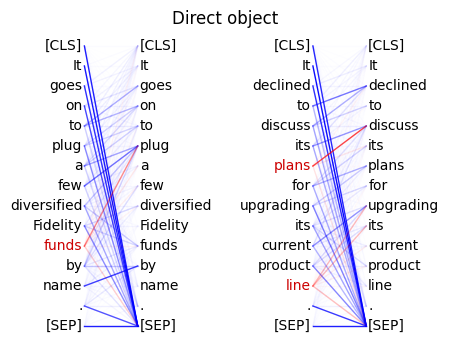

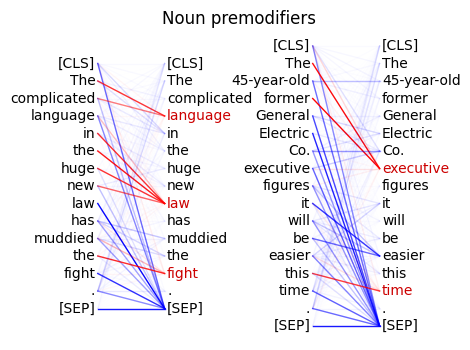

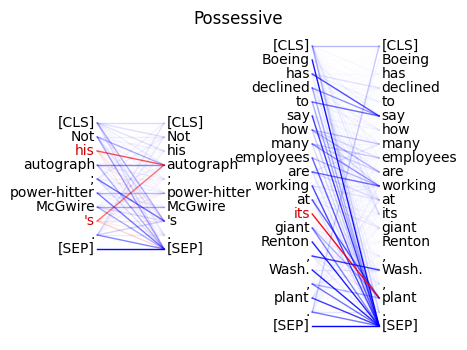

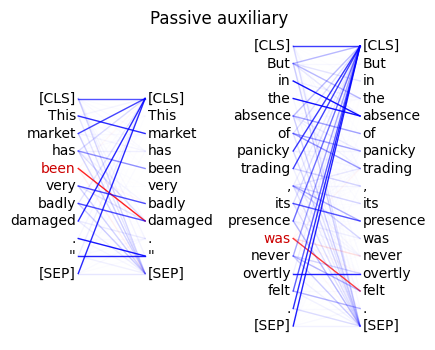

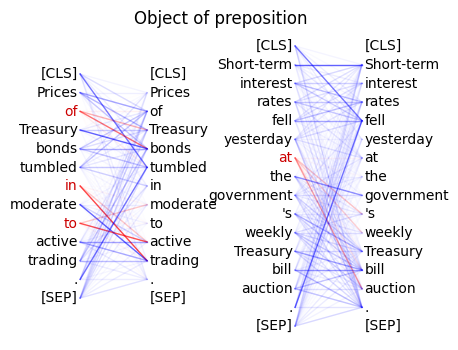

In [8]:
from typing import Any, Dict, List


def plot_attn(title: str,
              examples: List[Dict[str, Any]],
              layer: int,
              head: int,
              color_words: List[str] = [],
              color_from=True,
              width: int = 3,
              example_sep: int = 3, 
              word_height: int = 1,
              pad: float = 0.1,
              hide_sep: bool = False) -> None:
  """Plot BERT's attention for a particular head/example.
  
  Args:
    title: The title of the plot.
    examples: A list of two examples to compare.
    layer: The layer of BERT to plot.
    head: The head of BERT to plot.
    color_words: A list of words to color red.
    color_from: Whether to color words in color_words red when they are the
      source of attention (True) or the destination (False).
    width: The width of each example in the plot.
    example_sep: The separation between the two examples in the plot.
    word_height: The height of each word in the plot.
    pad: The padding between words in the plot.
    hide_sep: Whether to hide the [SEP] token in the plot.
  """
  plt.figure(figsize=(4, 4))
  for i, example in enumerate(examples):
    yoffset = 0
    if i == 0:
      yoffset += (len(examples[0]["words"]) -
                  len(examples[1]["words"])) * word_height / 2
    xoffset = i * width * example_sep
    attn = example["attns"][layer][head]
    if hide_sep:
      attn = np.array(attn)
      attn[:, 0] = 0
      attn[:, -1] = 0
      attn /= attn.sum(axis=-1, keepdims=True)

    words = ["[CLS]"] + example["words"] + ["[SEP]"]
    n_words = len(words)
    for position, word in enumerate(words):
      for x, from_word in [(xoffset, True), (xoffset + width, False)]:
        color = "k"
        if from_word == color_from and word in color_words:
          color = "#cc0000"
        plt.text(x, yoffset - (position * word_height), word,
                 ha="right" if from_word else "left", va="center",
                 color=color)

    for i in range(n_words):
      for j in range(n_words):
        color = "b"
        if words[i if color_from else j] in color_words:
          color = "r"
        plt.plot([xoffset + pad, xoffset + width - pad],
                 [yoffset - word_height * i, yoffset - word_height * j],
                 color=color, linewidth=1, alpha=attn[i, j])
  plt.axis("off")
  plt.title(title)
  plt.show()

# Examples from Figure 5 of the paper.
plot_attn(
  title="Direct object",
  examples=[dev_data[42], dev_data[1286]],
  layer=7,
  head=9, 
  color_words=["funds", "plans", "line"],
  example_sep=4
)
plot_attn(
  title="Noun premodifiers",
  examples=[dev_data[13], dev_data[1671]],
  layer=7,
  head=10,
  color_words=["language", "law", "fight", "time", "executive"],
  color_from=False
)
plot_attn(
  title="Possessive",
  examples=[dev_data[111], dev_data[244]],
  layer=6,
  head=5,
  color_words=["his", "'s", "its"]
)
plot_attn(
  title="Passive auxiliary",
  examples=[dev_data[192], dev_data[680]],
  layer=3,
  head=9,
  color_words=["been", "was"]
)
plot_attn(
  title="Object of preposition",
  examples=[dev_data[975], dev_data[979]],
  layer=8,
  head=5,
  color_words=["in", "with", "to", "of", "at"],
  hide_sep=True
)

poss     |   791 | attn: 28.1 | offset= 0: 42.4 | 6-11 head<-dep
Layer: 6, Head: 11, Direction: head<-dep


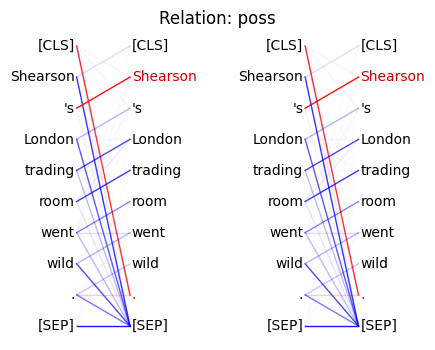

nsubj    |  3368 | attn: 17.4 | offset= 0: 43.9 | 6-11 head<-dep
Layer: 6, Head: 11, Direction: head<-dep


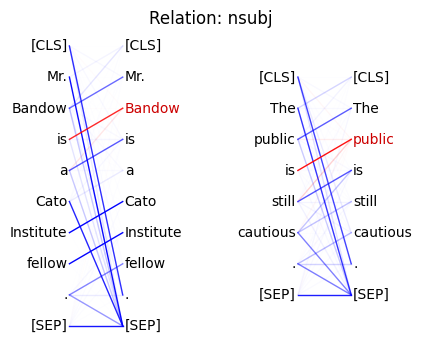

dobj     |  1516 | attn: 29.4 | offset=-3: 37.4 | 5-8 head<-dep
Layer: 5, Head: 8, Direction: head<-dep


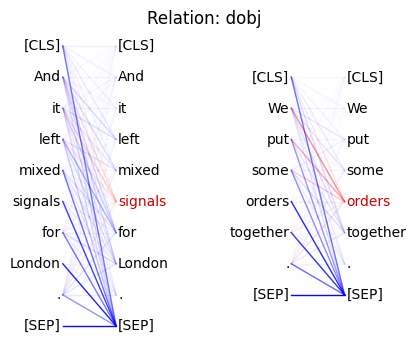

det      |  4329 | attn: 25.0 | offset= 0: 35.7 | 5-9 dep->head
Layer: 5, Head: 9, Direction: dep->head


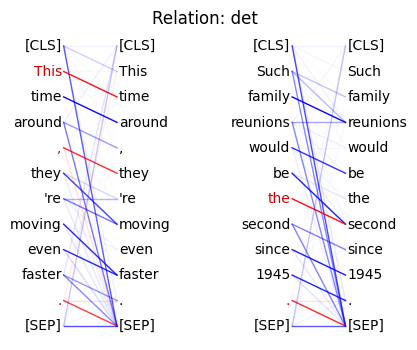

In [18]:
# Generate plot for actual data
# e.g. poss     |   791 | attn: 28.1 | offset= 0: 42.4 | 6-11 head<-dep
import random

def plot_reln(reln: str):
    uas, layer, head, direction = sorted(
        s for s in get_all_scores(reln))[-1]
    baseline_uas, baseline_offset = max(
        (scores[reln], i) for i, scores in baseline_scores.items())

    print("{:8s} | {:5d} | attn: {:.1f} | offset={:2d}: {:.1f} | {:}-{:} {:}".format(
        reln[:8], reln_counts[reln], 100 * uas, baseline_offset, 100 * baseline_uas,
        layer, head, direction))

    examples = random.choices([ex for ex in dev_data if reln in ex["relns"] and len(ex["words"]) <= 10], k=2)
    color_words = [
        # color words that have the example["reln"] == reln
        example["words"][i]
        for example in examples
        for i in range(len(example["words"])) if example["relns"][i] == reln
    ]
    
    print(f"Layer: {layer}, Head: {head}, Direction: {direction}")

    plot_attn(
        title=f"Relation: {reln}",
        examples=examples,
        layer=layer,
        head=head,
        color_words=color_words,
        example_sep=4,
        color_from=(direction == "dep->head")
    )

plot_reln("poss")
plot_reln("nsubj")
plot_reln("dobj")
plot_reln("det")


### Probing classifiers (Section 5)

In [10]:
class WordEmbeddings(object):
  """Class for loading/using pretrained GloVe embeddings"""
    
  def __init__(self):
    self.pretrained_embeddings = load_pickle("./data/glove/embeddings.pkl")
    self.vocab = load_pickle("./data/glove/vocab.pkl")

  def tokid(self, w):
    return self.vocab.get(w.lower(), 0)

In [11]:
N_DISTANCE_FEATURES = 8
def make_distance_features(seq_len):
  """Constructs distance features for a sentence."""
  # how much ahead/behind the other word is
  distances = np.zeros((seq_len, seq_len))
  for i in range(seq_len):
    for j in range(seq_len):
      if i < j:
        distances[i, j] = (j - i) / float(seq_len)
  feature_matrices = [distances, distances.T]

  # indicator features on if other word is up to 2 words ahead/behind
  for k in range(3):
    for direction in ([1] if k == 0 else [-1, 1]):
      feature_matrices.append(np.eye(seq_len, k=k*direction))
  features = np.stack(feature_matrices)

  # additional indicator feature for ROOT
  features = np.concatenate(
      [np.zeros([N_DISTANCE_FEATURES - 1, seq_len, 1]), 
       features], -1)
  root = np.zeros((1, seq_len, seq_len + 1))
  root[:, :, 0] = 1

  return np.concatenate([features, root], 0)

In [12]:
def attn_linear_combo():
  return Probe()


def attn_and_words():
  return Probe(use_words=True)


def words_and_distances():
  return Probe(use_distance_features=True, use_attns=False,
               use_words=True, hidden_layer=True)


class Probe(object):
  """The probing classifier used in Section 5."""

  def __init__(self, use_distance_features=False, use_words=False,
               use_attns=True, include_transpose=True, hidden_layer=False):
    self._embeddings = WordEmbeddings()

    # We use a simple model with batch size 1
    self._attns = tf.compat.v1.placeholder(
        shape=[12, 12, None, None], dtype=tf.float32)
    self._labels = tf.compat.v1.placeholder(
        shape=[None], dtype=tf.int32)
    self._features = tf.compat.v1.placeholder(
        shape=[N_DISTANCE_FEATURES, None, None], dtype=tf.float32)
    self._words = tf.compat.v1.placeholder(shape=[None], dtype=tf.int32)

    if use_attns:
      seq_len = tf.shape(self._attns)[-1]
      if include_transpose:
        # Include both directions of attention
        attn_maps = tf.concat(
            [self._attns,
             tf.transpose(self._attns, [0, 1, 3, 2])], 0)
        attn_maps = tf.reshape(attn_maps, [288, seq_len, seq_len])
      else:
        attn_maps = tf.reshape(self._attns, [144, seq_len, seq_len])
      # Use attention to start/end tokens to get score for ROOT
      root_features = (
          (tf.compat.v1.get_variable("ROOT_start", shape=[]) * attn_maps[:, 1:-1, 0]) +
          (tf.compat.v1.get_variable("ROOT_end", shape=[]) * attn_maps[:, 1:-1, -1])
      )
      attn_maps = tf.concat([tf.expand_dims(root_features, -1),
                             attn_maps[:, 1:-1, 1:-1]], -1)
    else:
      # Dummy attention map for models not using attention inputs
      n_words = tf.shape(self._words)[0]
      attn_maps = tf.zeros((1, n_words, n_words + 1))

    if use_distance_features:
      attn_maps = tf.concat([attn_maps, self._features], 0)

    if use_words:
      word_embedding_matrix = tf.compat.v1.get_variable(
          "word_embedding_matrix",
          initializer=self._embeddings.pretrained_embeddings,
          trainable=False)
      word_embeddings = tf.nn.embedding_lookup(word_embedding_matrix, self._words)
      n_words = tf.shape(self._words)[0]
      tiled_vertical = tf.tile(tf.expand_dims(word_embeddings, 0),
                               [n_words, 1, 1])
      tiled_horizontal = tf.tile(tf.expand_dims(word_embeddings, 1),
                                 [1, n_words, 1])
      word_reprs = tf.concat([tiled_horizontal, tiled_vertical], -1)
      word_reprs = tf.concat([word_reprs, tf.zeros((n_words, 1, 200))], 1) # dummy for ROOT
      if not use_attns:
        attn_maps = tf.concat([
            attn_maps, tf.transpose(word_reprs, [2, 0, 1])], 0)

    attn_maps = tf.transpose(attn_maps, [1, 2, 0])
    if use_words and use_attns:
      # attention-and-words probe
      weights = tf.compat.v1.layers.dense(word_reprs, attn_maps.shape[-1])
      self._logits = tf.reduce_sum(weights * attn_maps, axis=-1)
    else:
      if hidden_layer:
        # 1-hidden-layer MLP for words-and-distances baseline
        attn_maps = tf.compat.v1.layers.dense(attn_maps, 256,
                                    activation=tf.nn.tanh)
        self._logits = tf.squeeze(tf.compat.v1.layers.dense(attn_maps, 1), -1)
      else:
        # linear combination of attention heads
        attn_map_weights = tf.compat.v1.get_variable("attn_map_weights",
                                           shape=[attn_maps.shape[-1]])
        self._logits = tf.reduce_sum(attn_map_weights * attn_maps, axis=-1)

    loss = tf.reduce_sum(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=self._logits, labels=self._labels))
    opt = tf.compat.v1.train.AdamOptimizer(learning_rate=0.002)
    self._train_op = opt.minimize(loss)

  def _create_feed_dict(self, example):
    return {
        self._attns: example["attns"],
        self._labels: example["heads"],
        self._features: make_distance_features(len(example["words"])),
        self._words: [self._embeddings.tokid(w) for w in example["words"]]
    }

  def train(self, sess, example):
    return sess.run(self._train_op, feed_dict=self._create_feed_dict(example))

  def test(self, sess, example):
    return sess.run(self._logits, feed_dict=self._create_feed_dict(example))


def run_training(probe: Probe, train_data):
  """Trains and evaluates the given attention probe."""
  with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

    for epoch in range(1):
      print(40 * "=")
      print("EPOCH", (epoch + 1))
      print(40 * "=")
      print("Training...")
      for i, example in enumerate(train_data):
        if i % 2000 == 0:
          print("{:}/{:}".format(i, len(train_data)))
        probe.train(sess, example)

      print("Evaluating...")
      correct, total = 0, 0
      for i, example in enumerate(dev_data):
        if i % 1000 == 0:
          print("{:}/{:}".format(i, len(dev_data)))
        logits = probe.test(sess, example)
        for i, (head, prediction, reln) in enumerate(
            zip(example["heads"], logits.argmax(-1), example["relns"])):
          # it is standard to ignore punct for Stanford Dependency evaluation
          if reln != "punct":
            if head == prediction:
              correct += 1
            total += 1
      print("UAS: {:.1f}".format(100 * correct / total))

In [13]:
# tf.compat.v1.reset_default_graph()
# train_data_unprocessesed = load_pickle("./data/depparse/train_attn.pkl")
# train_data = []
# for i, example in enumerate(train_data_unprocessesed, start=1):
#     print(f"Example {i}/{len(train_data_unprocessesed)}", end="\r")
#     heads, rels = get_word_info(example["words"])
#     train_data.append({
#         "words": example["words"],
#         "heads": heads,
#         "relns": rels,
#         "attns": example["attns"]
#     })
# run_training(attn_and_words(), train_data)